In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install pandas
#!pip install tqdm

#!pip install scipy
#!pip install matchms
#!pip install scikit-learn
#!pip install spec2vec
#!pip install seaborn

In [3]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [4]:
from src.transformers.sklearn_model import SklearnModel

In [252]:
import gensim
from src.load_data import LoadData
from src.config import Config
from matchms import calculate_scores
from matchms.importing import load_from_mgf,load_from_msp
import matchms.filtering as msfilters
from spec2vec import SpectrumDocument
from spec2vec.model_building import train_new_word2vec_model
from tqdm import tqdm
from src.loader_saver import LoaderSaver
import itertools
import numpy as np
from matchms.importing import load_from_msp
from matchms.similarity import ModifiedCosine
from scipy.stats import spearmanr
import dill
from src.plotting import Plotting
from src.load_data import LoadData
from sklearn.model_selection import train_test_split
from src.train_utils import TrainUtils
from src.preprocessor import Preprocessor
from matchms.filtering import add_fingerprint
import pickle
import sys
from src.config import Config
from src.parser import Parser
from datetime import datetime
from src.loader_saver import LoaderSaver
from src.spec2vec_comparison import Spec2VecComparison
from src.ms2deepscore_comparison import MS2DeepScoreComparison
from src.molecular_pairs_set import MolecularPairsSet
from src.molecule_pairs_opt import MoleculePairsOpt
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [6]:
from src.transformers.embedder import Embedder

In [7]:
ls /Users/sebas/projects/data

ALL_GNPS_NO_PROPOGATED_wb.mgf
GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf
all_spectrums_gnps.pkl
all_spectrums_gnps_nist_20240130_gnps_nist_janssen.pkl
all_spectrums_janssen.pkl
all_spectrums_nist.pkl
best_model.ckpt
best_model_128n_10_layers_20240209.ckpt
best_model_128n_5_layers_20240219_elementwise.ckpt
best_model_128n_5_layers_20240229.ckpt
best_model_128n_5_layers_20240303.ckpt
best_model_20240301.ckpt
best_model_20240318_lib_cos_sim.ckpt
drug_plus.mgf
hr_msms_nist_all.MSP*
hr_msms_nist_sample.MSP
merged_gnps_nist_20240118_gnps_nist_janssen.pkl
merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl
merged_gnps_nist_20240227_gnps_nist_janssen_20_millions_OUTSIDE_MAX_DIFF_NO_JANSSEN.pkl
merged_gnps_nist_20240311_unique_smiles_1_million.pkl
ms2deepscore_positive_10k_1000_1000_1000_500.hdf5
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.trainables.syn1neg.npy
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.

## Parameters

In [24]:
data_folder= '/Users/sebas/projects/data/'
dataset_path = data_folder + 'uniformed_molecule_pairs_test.pkl'
gnps_path =  data_folder + 'ALL_GNPS_NO_PROPOGATED_wb.mgf'
janssen_path = data_folder + 'drug_plus.mgf'
nist_path = data_folder + 'hr_msms_nist_all.MSP'
output_pairs_file= data_folder + 'molecular_pairs.pkl'
output_nist_file= data_folder + 'all_spectrums_nist.pkl'
output_gnps_file= data_folder + 'all_spectrums_gnps.pkl'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'
model_spec2vec_file = data_folder + 'spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model'
model_ms2d_file= data_folder + 'ms2deepscore_positive_10k_1000_1000_1000_500.hdf5'
#uniformed_molecule_pairs_test_path= data_folder +'uniformed_molecule_pairs_test.pkl'
uniformed_molecule_pairs_test_path= data_folder +'merged_gnps_nist_20240311_unique_smiles_1_million.pkl'
#transformer_path = data_folder + 'best_model_128n_5_layers_20240219_elementwise.ckpt'
transformer_path = data_folder + 'best_model_20240318_lib_cos_sim.ckpt'

In [9]:
THRESHOLD_ANALOG=0.7

In [10]:
load_molecule_pairs_file= True
only_use_gnps=False

In [11]:
## Load spectrum using spectrumutils

In [12]:
config=Config()

## Load molecular pairs

In [310]:

if load_molecule_pairs_file:
        with open(uniformed_molecule_pairs_test_path, 'rb') as file:
            dataset = dill.load(file)
        original_molecule_pairs= dataset['uniformed_molecule_pairs_test']
else:
        number_pairs=10000
        original_molecule_pairs= TrainUtils.compute_all_tanimoto_results(all_spectrums, 
                                                                max_combinations=number_pairs, 
                                                                use_tqdm=True, 
                                                                max_mass_diff=config.MAX_MASS_DIFF, 
                                                                min_mass_diff=config.MIN_MASS_DIFF)

In [311]:
len(original_molecule_pairs)

40940

In [312]:
if only_use_gnps:
    molecule_pairs = original_molecule_pairs.get_gnps_pairs()
else:
    molecule_pairs=original_molecule_pairs

In [313]:
len(molecule_pairs)

40940

## Our model

In [315]:
from src.transformers.sklearn_model import SklearnModel

In [316]:
#temp_molecule_pairs= MolecularPairsSet(spectrums= molecule_pairs.spectrums, 
#                                      indexes_tani =molecule_pairs.indexes_tani)
temp_molecule_pairs= molecule_pairs

In [317]:
#model = Embedder.load_from_checkpoint(
 #           checkpoint_path=transformer_path, d_model=config.D_MODEL, n_layers=config.N_LAYERS
#        )

In [318]:
model =SklearnModel(model_path=transformer_path, d_model=config.D_MODEL, n_layers=config.N_LAYERS)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Using cosine library from Pytorch?: True


In [319]:
#next(iter(dataloader_test))

In [320]:
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] 

'1'

In [327]:
scores_trans=model.predict_from_molecule_pair(temp_molecule_pairs)

Preprocessing all the data ...


33719it [00:00, 77322.04it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40940/40940 [00:00<00:00, 112267.71it/s]


Preprocessing all the data ...


33719it [00:00, 77185.78it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [328]:
scores_trans

array([0.03232374, 0.29673687, 0.02780199, ..., 0.81697559, 0.97845054,
       0.92268348])

In [329]:
tanimoto_trans = [row[2] for row in molecule_pairs.indexes_tani]

In [330]:
tanimoto_trans_binary=[1 if t>THRESHOLD_ANALOG else 0 for t in tanimoto_trans]
scores_trans=[s if s>0 else 0 for s in (scores_trans)]

In [331]:
spearman_trans = spearmanr(tanimoto_trans, scores_trans)
spearman_trans

SignificanceResult(statistic=0.9001548735189688, pvalue=0.0)

tpr: [0.         0.00341964 0.02589155 ... 1.         1.         1.        ]
fpr: [0.         0.         0.         ... 0.98206435 0.98213413 1.        ]


(array([0.        , 0.00341964, 0.02589155, ..., 1.        , 1.        ,
        1.        ]),
 array([0.        , 0.        , 0.        , ..., 0.98206435, 0.98213413,
        1.        ]))

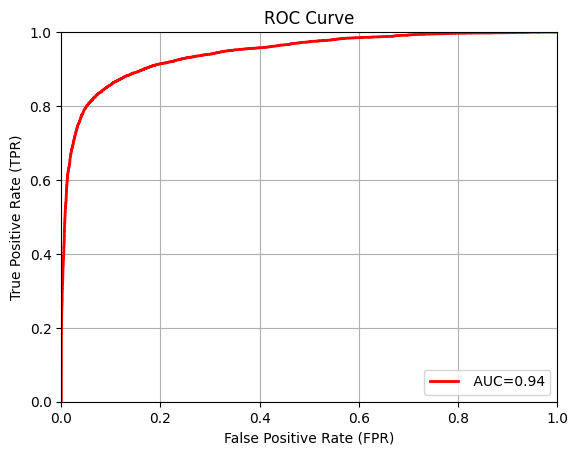

In [332]:
Plotting.plot_roc_curve(tanimoto_trans_binary, scores_trans)

In [333]:
temp_molecule_pairs.prediction = scores_trans

In [334]:
## Separate false positives

In [335]:
molecule_fp = [m for m,s in zip(temp_molecule_pairs, scores_trans) if (s>THRESHOLD_ANALOG)and (m.similarity<THRESHOLD_ANALOG)]

In [336]:
molecule_tp = [m for m,s in zip(temp_molecule_pairs, scores_trans) if (s>THRESHOLD_ANALOG)and (m.similarity>THRESHOLD_ANALOG)]

In [337]:
molecule_tn = [m for m,s in zip(temp_molecule_pairs, scores_trans) if (s<THRESHOLD_ANALOG)and (m.similarity<THRESHOLD_ANALOG)]

In [338]:
molecule_fn = [m for m,s in zip(temp_molecule_pairs, scores_trans) if (s<THRESHOLD_ANALOG)and (m.similarity>THRESHOLD_ANALOG)]

In [339]:
## There is a difference in precursor mass difference?

In [340]:
diff_mass_fp = [abs(m.spectrum_object_1.precursor_mz - m.spectrum_object_0.precursor_mz) for m in molecule_fp]

In [341]:
diff_mass_tp = [abs(m.spectrum_object_1.precursor_mz - m.spectrum_object_0.precursor_mz) for m in molecule_tp]

In [342]:
diff_mass_tn = [abs(m.spectrum_object_1.precursor_mz - m.spectrum_object_0.precursor_mz) for m in molecule_tn]

In [343]:
diff_mass_fn = [abs(m.spectrum_object_1.precursor_mz - m.spectrum_object_0.precursor_mz) for m in molecule_fn]

In [344]:
diff_mass_positives= diff_mass_tp + diff_mass_fn
diff_mass_negatives = diff_mass_tn + diff_mass_fp

In [345]:
len(molecule_tp), len(molecule_fn)

(9564, 2718)

In [346]:
len(molecule_tn), len(molecule_fp)

(27429, 1229)

Text(0.5, 0, 'diff mass')

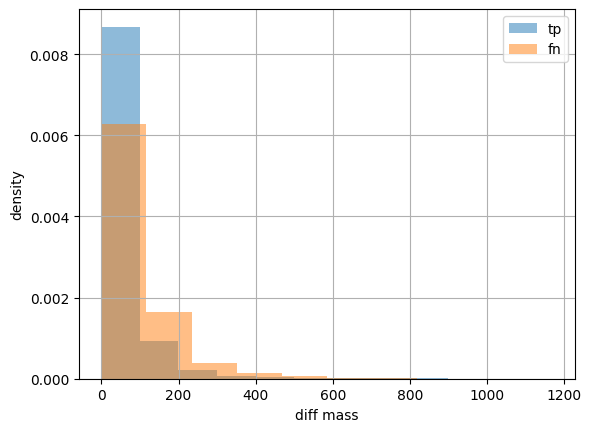

In [347]:
_= plt.hist(diff_mass_tp, label ='tp', alpha=0.5,bins=10, density=True)
_= plt.hist(diff_mass_fn, label ='fn', alpha=0.5,bins=10, density=True)
plt.legend()
plt.grid()
plt.ylabel('density')
plt.xlabel('diff mass')

Text(0.5, 0, 'diff mass')

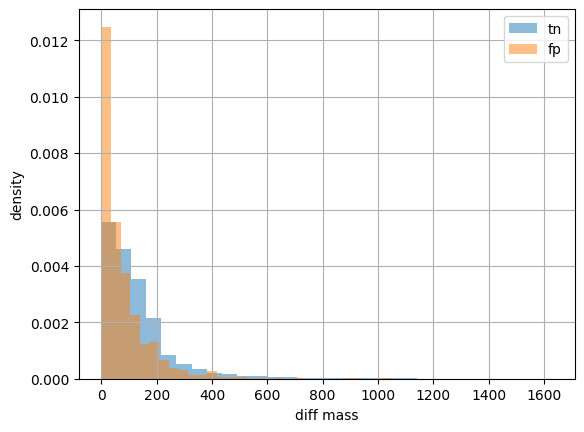

In [348]:
_=plt.hist(diff_mass_tn, label='tn', alpha=0.5, bins=30,density=True)
_= plt.hist(diff_mass_fp, label ='fp', alpha=0.5,bins=30, density=True)
plt.legend()
plt.grid()
plt.ylabel('density')
plt.xlabel('diff mass')

Text(0.5, 0, 'diff mass')

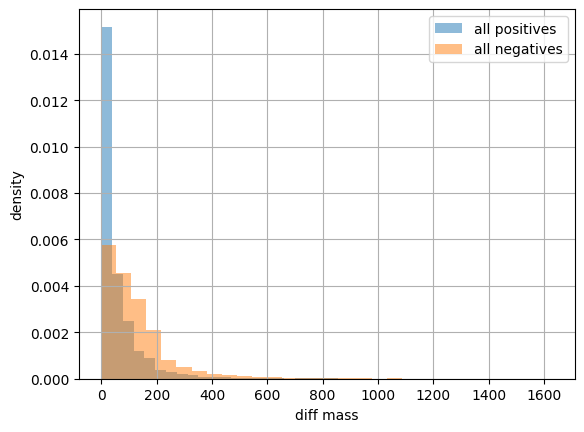

In [349]:
_=plt.hist(diff_mass_positives, label='all positives', alpha=0.5, bins=30,density=True)
_= plt.hist(diff_mass_negatives, label ='all negatives', alpha=0.5,bins=30, density=True)
plt.legend()
plt.grid()
plt.ylabel('density')
plt.xlabel('diff mass')

(array([2.0386e+04, 5.2320e+03, 1.0630e+03, 4.0900e+02, 1.8100e+02,
        8.0000e+01, 4.2000e+01, 2.0000e+01, 1.4000e+01, 2.0000e+00]),
 array([   0.     ,  162.99308,  325.98616,  488.97924,  651.97232,
         814.9654 ,  977.95848, 1140.95156, 1303.94464, 1466.93772,
        1629.9308 ]),
 <BarContainer object of 10 artists>)

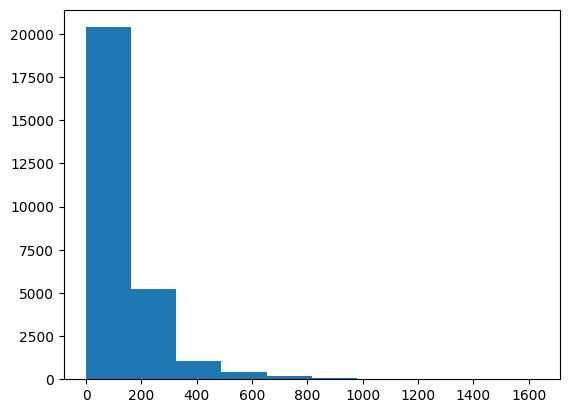

In [352]:
plt.hist(diff_mass_tn)

(array([1.998e+03, 5.210e+02, 1.260e+02, 4.100e+01, 2.400e+01, 2.000e+00,
        4.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([   0.     ,  116.84632,  233.69264,  350.53896,  467.38528,
         584.2316 ,  701.07792,  817.92424,  934.77056, 1051.61688,
        1168.4632 ]),
 <BarContainer object of 10 artists>)

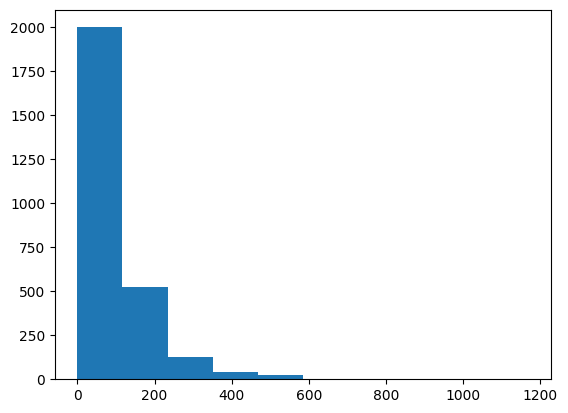

In [353]:
plt.hist(diff_mass_fn)

In [354]:
## Where the errors are ocurring more?
mass_fp = [min(m.spectrum_object_1.precursor_mz,m.spectrum_object_0.precursor_mz) for m in molecule_fp]

In [355]:
mass_tp = [min(m.spectrum_object_1.precursor_mz,m.spectrum_object_0.precursor_mz) for m in molecule_tp]

In [356]:
mass_tn = [min(m.spectrum_object_1.precursor_mz,m.spectrum_object_0.precursor_mz) for m in molecule_tn]

In [357]:
mass_fn = [min(m.spectrum_object_1.precursor_mz,m.spectrum_object_0.precursor_mz) for m in molecule_fn]

Text(0.5, 0, 'mass')

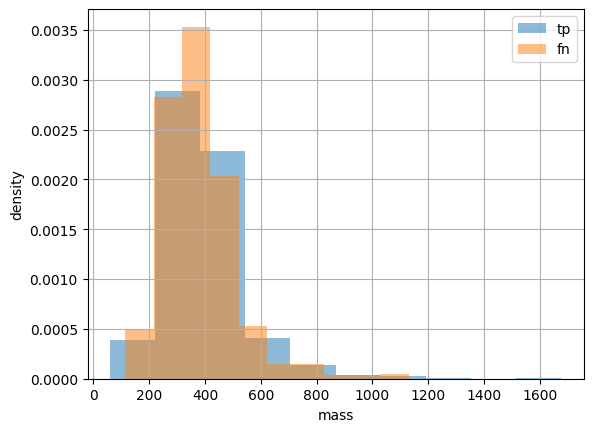

In [358]:
_= plt.hist(mass_tp, label ='tp', alpha=0.5,bins=10, density=True)
_= plt.hist(mass_fn, label ='fn', alpha=0.5,bins=10, density=True)
plt.legend()
plt.grid()
plt.ylabel('density')
plt.xlabel('mass')

Text(0.5, 0, 'mass')

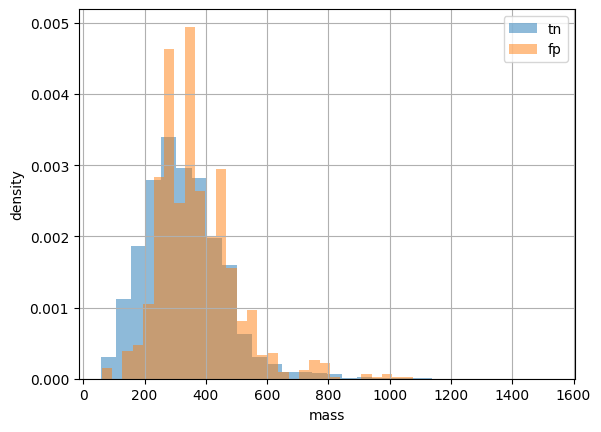

In [359]:
_=plt.hist(mass_tn, label='tn', alpha=0.5, bins=30,density=True)
_= plt.hist(mass_fp, label ='fp', alpha=0.5,bins=30, density=True)
plt.legend()
plt.grid()
plt.ylabel('density')
plt.xlabel('mass')

Text(0.5, 0, 'mass')

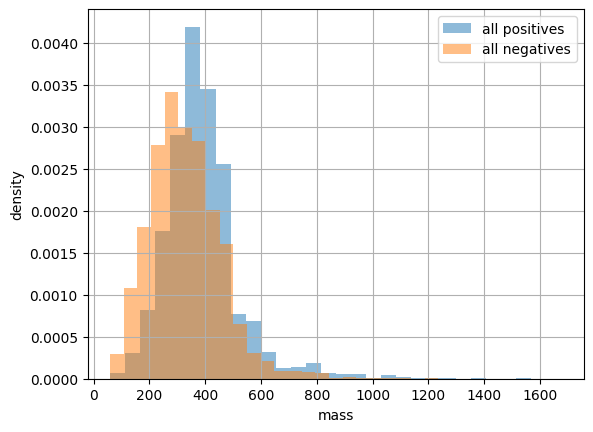

In [360]:
_=plt.hist(mass_tp + mass_fn, label='all positives', alpha=0.5, bins=30,density=True)
_= plt.hist(mass_tn + mass_fp, label ='all negatives', alpha=0.5,bins=30, density=True)
plt.legend()
plt.grid()
plt.ylabel('density')
plt.xlabel('mass')

Text(0.5, 0, 'mass')

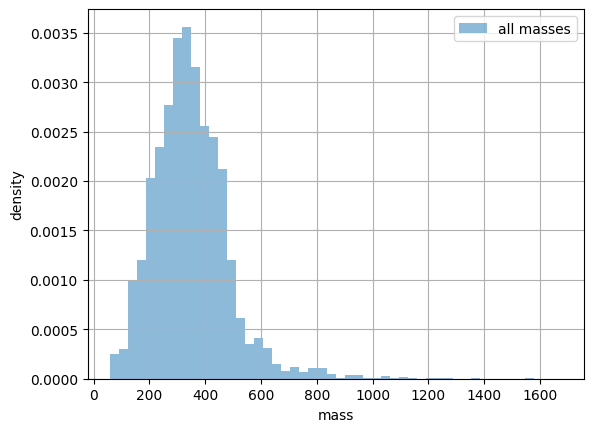

In [361]:
##all masses
_=plt.hist(mass_tp + mass_fn+mass_tn + mass_fp, label='all masses', alpha=0.5, bins=50,density=True)
plt.legend()
plt.grid()
plt.ylabel('density')
plt.xlabel('mass')

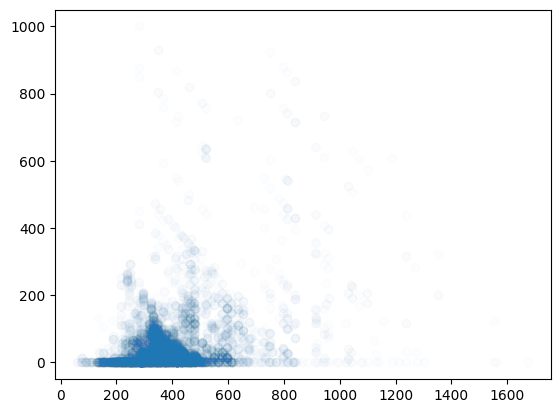

In [362]:
plt.scatter(mass_tp,diff_mass_tp, alpha=0.01)

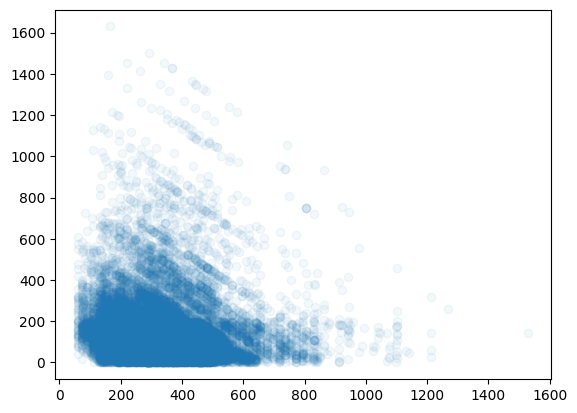

In [363]:
plt.scatter(mass_tn,diff_mass_tn, alpha=0.05)

## Are pairs with similarity equal 1 more prone to errors?

In [364]:
mol_1= [{'m':m,'score':s} for m,s in zip(temp_molecule_pairs,scores_trans) if m.similarity==1]

In [365]:
mol_090= [{'m':m,'score':s} for m,s in zip(temp_molecule_pairs,scores_trans)  if ((m.similarity<1)and(m.similarity>0.90))]

In [366]:
len(mol_1)

2401

In [367]:
len(mol_090)

1693

In [368]:
scores_1 = np.array([m['score'] for m in mol_1])

In [369]:
scores_090 = np.array([m['score'] for m in mol_090])

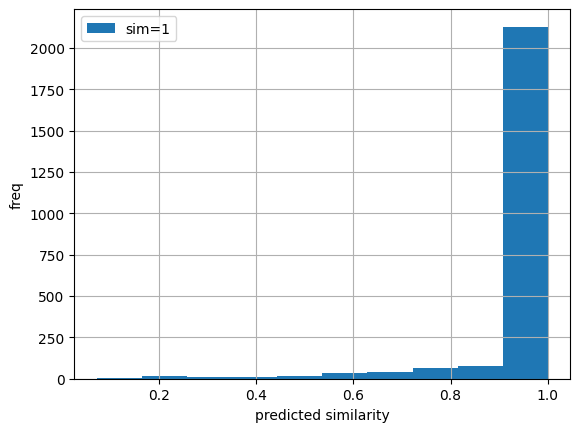

In [370]:
_=plt.hist(scores_1, label='sim=1')
plt.ylabel('freq')
plt.grid()
plt.xlabel('predicted similarity')
plt.legend()

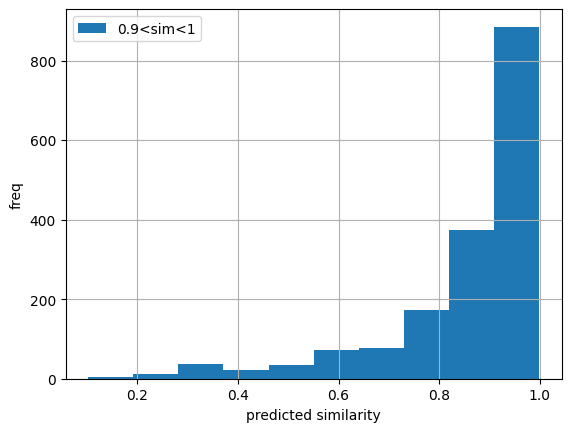

In [371]:
_=plt.hist(scores_090, label='0.9<sim<1')
plt.ylabel('freq')
plt.grid()
plt.xlabel('predicted similarity')
plt.legend()

In [372]:
len(scores_1[scores_1<0.5])/len(mol_1)

0.018742190753852563

In [373]:
len(scores_1[scores_1<0.5])

45

In [374]:
len(scores_090[scores_090<0.5])/len(scores_090)

0.05670407560543414

In [375]:
len(scores_090[scores_090<0.5])

96

In [376]:
scores_1[scores_1<0.5]

array([0.23490189, 0.36573255, 0.419792  , 0.19604167, 0.43839139,
       0.07561256, 0.41279209, 0.25057891, 0.07561256, 0.19604167,
       0.48934966, 0.23318326, 0.36573255, 0.26110935, 0.25057891,
       0.21658131, 0.07254265, 0.46451876, 0.46437103, 0.41279209,
       0.44841343, 0.35271049, 0.26110935, 0.20853691, 0.29893491,
       0.44841343, 0.34494674, 0.22991744, 0.20853691, 0.45120984,
       0.45120984, 0.38426635, 0.35271049, 0.39469385, 0.18245582,
       0.320236  , 0.29893491, 0.21658131, 0.34494674, 0.19844367,
       0.32048142, 0.46437103, 0.34395003, 0.19456744, 0.07254265])

In [377]:
scores_090[scores_090<0.5]

array([0.29684758, 0.45201153, 0.30625185, 0.31407544, 0.47789246,
       0.3774882 , 0.3140437 , 0.29536787, 0.31581011, 0.45002609,
       0.45517129, 0.15220572, 0.26897433, 0.42936361, 0.47789246,
       0.3624965 , 0.29254726, 0.37947464, 0.10210542, 0.48475894,
       0.29740521, 0.10210542, 0.48223066, 0.48470923, 0.43910214,
       0.41833344, 0.44060394, 0.30662978, 0.49692464, 0.47086024,
       0.18548031, 0.29740521, 0.23087373, 0.23087373, 0.20900545,
       0.4627592 , 0.33996832, 0.34167358, 0.3774882 , 0.44060394,
       0.21210305, 0.22500271, 0.36817342, 0.31177837, 0.23442566,
       0.48379511, 0.20900545, 0.2846266 , 0.44874567, 0.36346596,
       0.36743623, 0.23151559, 0.41833344, 0.22243321, 0.36346596,
       0.36743623, 0.4953934 , 0.4627592 , 0.31090575, 0.2846266 ,
       0.37711549, 0.15220572, 0.46070391, 0.45002609, 0.29254726,
       0.22500271, 0.47193706, 0.34169981, 0.37947464, 0.3140437 ,
       0.31177837, 0.37711549, 0.48470923, 0.30809754, 0.46070

In [378]:
len(temp_molecule_pairs)

40940

In [379]:
bad_mol_1 = [{'m':m,'score':s} for m,s in zip(temp_molecule_pairs,scores_trans)  if ((m.similarity==1)and(s<0.3))]

In [380]:
[{'m':m,'score':s} for m,s in zip(temp_molecule_pairs,scores_trans)]

[{'m': <src.molecule_pair.MoleculePair at 0x375b6c610>,
  'score': 0.03232374042272568},
 {'m': <src.molecule_pair.MoleculePair at 0x375b6f0d0>,
  'score': 0.29673686623573303},
 {'m': <src.molecule_pair.MoleculePair at 0x375b6ee50>,
  'score': 0.027801986783742905},
 {'m': <src.molecule_pair.MoleculePair at 0x37ffc69d0>,
  'score': 0.04170221835374832},
 {'m': <src.molecule_pair.MoleculePair at 0x375cc93d0>,
  'score': 0.06639231741428375},
 {'m': <src.molecule_pair.MoleculePair at 0x375cc9310>,
  'score': 0.059381481260061264},
 {'m': <src.molecule_pair.MoleculePair at 0x375cc92d0>,
  'score': 0.3176417052745819},
 {'m': <src.molecule_pair.MoleculePair at 0x375cc9290>,
  'score': 0.06178935617208481},
 {'m': <src.molecule_pair.MoleculePair at 0x375cc9250>,
  'score': 0.18880054354667664},
 {'m': <src.molecule_pair.MoleculePair at 0x375cc9350>,
  'score': 0.054052628576755524},
 {'m': <src.molecule_pair.MoleculePair at 0x375cc8fd0>,
  'score': 0.07462833821773529},
 {'m': <src.molecul

In [381]:
len(bad_mol_1)

22

In [382]:
bad_mol_1_gnps = [b for b in bad_mol_1 if (b['m'].params_0['spectrumid'].startswith('CCMS') and b['m'].params_1['spectrumid'].startswith('CCMS')) ]

In [383]:
len(bad_mol_1_gnps)

16

In [384]:
bad_mol_1_gnps[10]['m'].similarity

1.0

In [385]:
bad_mol_1_gnps[10]['score']

0.20853690803050995

In [386]:
bad_mol_1_gnps[10]['m'].smiles_0

'COCC(COC(C)=O)N(C)C(=O)CC/C=C/CCCCC(Cl)CCCCCCCl'

In [387]:
bad_mol_1_gnps[10]['m'].smiles_1

'COC[C@@H](COC(C)=O)N(C)C(=O)CC/C=C/CCCCC(Cl)CCCCCCCl'

In [388]:
bad_mol_1_gnps[10]['m'].params_1['smiles']

'ClCCCCCCC(Cl)CCCC/C=C/CCC(N(C)[C@@H](COC)COC(C)=O)=O'

In [389]:
bad_mol_1_gnps[10]['m'].params_0

{'pepmass': (466.04, None),
 'charge': [1],
 'mslevel': '2',
 'source_instrument': 'LC-ESI-Ion Trap',
 'filename': 'f.evgenia_glukhov/Cyano cultures/M_BOUILLONNII.mzXML;',
 'seq': '*..*',
 'ionmode': 'Positive',
 'organism': 'GNPS-LIBRARY',
 'name': 'Columbamide A M+H',
 'pi': 'Gerwick',
 'datacollector': 'Jenia',
 'smiles': 'ClCCCCCCC(Cl)CCCC/C=C/CCC(N(C)C(COC)COC(C)=O)=O',
 'inchi': '',
 'inchiaux': '',
 'pubmed': '26149623',
 'submituser': 'evgenia_glukhov',
 'libraryquality': '3',
 'spectrumid': 'CCMSLIB00000531496',
 'scans': '817'}

In [390]:
bad_mol_1_gnps[10]['m'].params_1

{'pepmass': (466.248, None),
 'charge': [1],
 'mslevel': '2',
 'source_instrument': 'LC-ESI-qTof',
 'filename': 'f.RReher/Golden lab/ColumbamideA-C_reference/ColumbamideA.mgf;',
 'seq': '*..*',
 'ionmode': 'Positive',
 'organism': 'GNPS-LIBRARY',
 'name': 'Columbamide A M+H',
 'pi': 'Gerwick',
 'datacollector': 'Kleigrewe',
 'smiles': 'ClCCCCCCC(Cl)CCCC/C=C/CCC(N(C)[C@@H](COC)COC(C)=O)=O',
 'inchi': '',
 'inchiaux': '',
 'pubmed': '',
 'submituser': 'RReher',
 'libraryquality': '3',
 'spectrumid': 'CCMSLIB00005464636',
 'scans': '1'}

In [391]:
from rdkit import Chem

In [392]:
Chem.CanonSmiles(bad_mol_1_gnps[10]['m'].smiles_0)

'COCC(COC(C)=O)N(C)C(=O)CC/C=C/CCCCC(Cl)CCCCCCCl'

In [393]:
Chem.CanonSmiles(bad_mol_1_gnps[10]['m'].params_0['smiles'])

'COCC(COC(C)=O)N(C)C(=O)CC/C=C/CCCCC(Cl)CCCCCCCl'

In [394]:
Chem.CanonSmiles(bad_mol_1_gnps[10]['m'].smiles_1)

'COC[C@@H](COC(C)=O)N(C)C(=O)CC/C=C/CCCCC(Cl)CCCCCCCl'

In [395]:
bad_mol_1_gnps[10]['m'].smiles_0

'COCC(COC(C)=O)N(C)C(=O)CC/C=C/CCCCC(Cl)CCCCCCCl'

In [396]:
bad_mol_1_gnps[10]['m'].params_0['smiles']

'ClCCCCCCC(Cl)CCCC/C=C/CCC(N(C)C(COC)COC(C)=O)=O'

In [397]:
smiles_0=bad_mol_1_gnps[10]['m'].smiles_0

In [398]:
smiles_1=bad_mol_1_gnps[10]['m'].smiles_1

In [399]:
bad_mol_1_gnps[10]['m'].similarity

1.0

In [400]:
from rdkit.Chem import DataStructs
mol_0 = Chem.MolFromSmiles(smiles_0)
fp_0 = Chem.RDKFingerprint(mol_0) 

mol_1 = Chem.MolFromSmiles(smiles_1)
fp_1 = Chem.RDKFingerprint(mol_1)
similarity = DataStructs.TanimotoSimilarity(fp_0, fp_1)

In [401]:
smiles_0

'COCC(COC(C)=O)N(C)C(=O)CC/C=C/CCCCC(Cl)CCCCCCCl'

In [402]:
smiles_1

'COC[C@@H](COC(C)=O)N(C)C(=O)CC/C=C/CCCCC(Cl)CCCCCCCl'

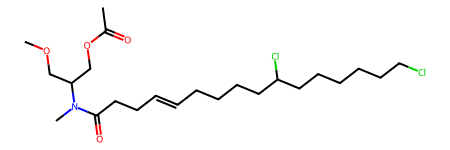

In [403]:
mol_0

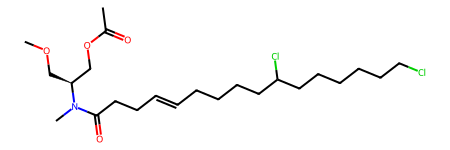

In [404]:
mol_1

In [405]:
similarity

1.0

## Pass the spectrum through the model

In [406]:
import pandas as pd
df_smiles = pd.DataFrame()
df_smiles['indexes']=[[0],[1]]

In [407]:
bad_mol_1_gnps[10]['m'].spectrum_object_0

In [408]:
test_pair = MoleculePairsOpt(spectrums_unique=[bad_mol_1_gnps[10]['m'].spectrum_object_0,bad_mol_1_gnps[10]['m'].spectrum_object_1],
                             spectrums_original=[bad_mol_1_gnps[10]['m'].spectrum_object_0, bad_mol_1_gnps[10]['m'].spectrum_object_1],
                             df_smiles=df_smiles,
                             indexes_tani_unique=np.array([[0,1,1]]))

In [409]:
scores_trans=model.predict_from_molecule_pair(test_pair)

Preprocessing all the data ...


2it [00:00, 9664.29it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4215.38it/s]


Preprocessing all the data ...


2it [00:00, 16946.68it/s]

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [410]:
scores_trans

array([0.20853683])

In [411]:
test_pair[0].smiles_0

'ClCCCCCCC(Cl)CCCC/C=C/CCC(N(C)C(COC)COC(C)=O)=O'

In [412]:
test_pair[0].smiles_1

'ClCCCCCCC(Cl)CCCC/C=C/CCC(N(C)[C@@H](COC)COC(C)=O)=O'

In [413]:
test_pair[0].similarity

1.0